## Sfincs results: maximum water depth

In [1]:
# import dependencies
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import hydromt
from hydromt_sfincs import SfincsModel

### Read model results

The model results in sfincs_map.nc are saved as in a staggered grid format, see [SGRID convention](https://publicwiki.deltares.nl/display/NETCDF/Deltares+proposal+for+Staggered+Grid+data+model+(SGRID)). Here we show how to retrieve the face values and translate the dimensions from node indices (m, n) to (x, y) coordinates in order to plot the results on a map.

In [2]:
sfincs_root = "sfincs_riverine"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r")

In [3]:
# we can simply read the model results (sfincs_map.nc and sfincs_his.nc) using the read_results method
mod.read_results()
# the following variables have been found
list(mod.results.keys())

['inp',
 'msk',
 'qinf',
 'zb',
 'zs',
 'h',
 'zsmax',
 'hmax',
 'cuminf',
 'total_runtime',
 'average_dt',
 'point_zb',
 'point_zs',
 'point_h',
 'point_u',
 'point_v',
 'point_qinf']

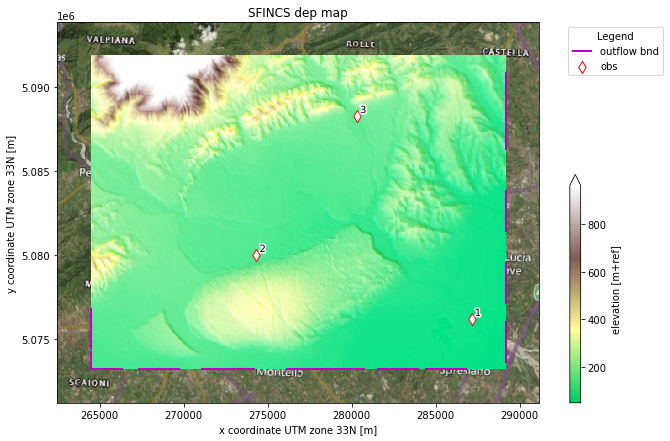

In [4]:
fig, ax = mod.plot_basemap(fn_out=None, bmap="sat", figsize=(11, 7))

### Write maximum waterdepth to geotiff file

In [5]:
# write hmax to <mod.root>/gis/hmax.tif
mod.write_raster("results.hmax", compress="LZW")

# this is identical to the following:
# hmax = mod.results['hmax']
# hmax = hmax.reindex(y=list(reversed(hmax['y'].values))) # change orientation to N -> S
# hmax.raster.to_raster(join(mod.root, 'gis', 'hmax.tif'), compress='LZW')

### Plot maximum water depth with surface water mask 

First we mask the water depth based on a map of permanent water to get the flood extent. 
The mask is calculated from the Global Surface Water Occurence (GSWO) dataset. 

In [6]:
# read global surface water occurance (GSWO) data to mask permanent water
# NOTE to read data for a different region than Northen Italy add this data to the data catalog:
# mod.data_catalog.from_yml('/path/to/data_catalog.yml')
print(mod.data_catalog["gswo"])
gswo = mod.data_catalog.get_rasterdataset("gswo", buffer=10)
# permanent water where water occurence > 5%
gswo_mask = gswo.raster.reproject_like(mod.staticmaps, method="max") <= 5

{'category': 'surface water',
 'data_type': 'RasterDataset',
 'driver': 'raster',
 'paper_doi': '10.1038/nature20584',
 'paper_ref': 'Pekel et al. (2016)',
 'path': '/home/runner/.hydromt_data/data/v0.0.5/gswo.tif',
 'source_url': 'https://global-surface-water.appspot.com/download',
 'source_version': 'v1_1_2019'}


In [7]:
hmin = 0.2  # minimum flood depth [m] to plot
da_hmax = mod.results["hmax"]  # hmax is computed from zsmax - zb
# get overland flood depth with GSWO and set minimum flood depth
da_hmax_fld = da_hmax.where(gswo_mask).where(da_hmax > hmin)
# update attributes for colorbar label later
da_hmax.attrs.update(long_name="flood depth", unit="m")

Here we plot the maximum water depth on top of the `plot_basemaps` method to also include the locations of discharge source points and observation gauge locations.

Text(0.5, 1.0, 'SFINCS maximum water depth')

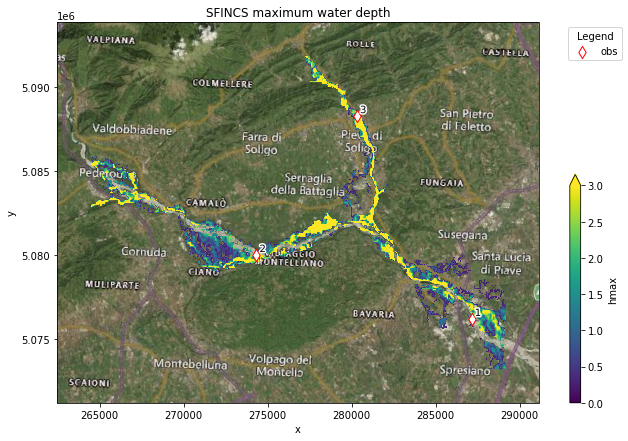

In [8]:
# create hmax plot and save to mod.root/figs/hmax.png
fig, ax = mod.plot_basemap(
    fn_out=None,
    variable=None,
    bmap="sat",
    geoms=["src", "obs"],
    plot_bounds=False,
    figsize=(11, 7),
)
# plot overland flooding based on gswo mask and mimum flood depth
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
cax_fld = da_hmax_fld.plot(
    ax=ax, vmin=0, vmax=3.0, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)

ax.set_title(f"SFINCS maximum water depth")
# plt.savefig(join(mod.root, 'figs', 'hmax.png'), dpi=225, bbox_inches="tight")